In [1]:
# import os
# import random
import numpy as np
import tensorflow as tf
import gym
# import tensorflow_probability as tfp
from tensorflow.keras import backend as K
import copy
# import time

C:\Users\Nikhil\anaconda3\envs\myenv\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
from tensorboardX import SummaryWriter

In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:
import pylab
# import matplotlib.pyplot as plt

In [5]:
from tensorflow.keras.layers import Input, Dense

In [6]:
class Actor_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Dense(512, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X_input)
        X = Dense(256, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        X = Dense(64, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        output = Dense(self.action_space, activation="softmax")(X)

        self.Actor = tf.keras.Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))

    def ppo_loss(self, y_true, y_pred):
        # Defined in https://arxiv.org/abs/1707.06347
        advantages = y_true[:, :1]
        prediction_picks = y_true[:, 1:1+self.action_space]
        actions = y_true[:, 1+self.action_space:]

        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def predict(self, state):
        return self.Actor.predict(state)

In [7]:
class Critic_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        old_values = Input(shape=(1,))

        V = Dense(512, activation="relu", kernel_initializer='he_uniform')(X_input)
        V = Dense(256, activation="relu", kernel_initializer='he_uniform')(V)
        V = Dense(64, activation="relu", kernel_initializer='he_uniform')(V)
        value = Dense(1, activation=None)(V)

        self.Critic = tf.keras.Model(inputs=[X_input, old_values], outputs = value)
        self.Critic.compile(loss=[self.critic_PPO2_loss(old_values)], optimizer=optimizer(lr=lr))

    def critic_PPO2_loss(self, values):
        def loss(y_true, y_pred):
            LOSS_CLIPPING = 0.2
            clipped_value_loss = values + K.clip(y_pred - values, -LOSS_CLIPPING, LOSS_CLIPPING)
            v_loss1 = (y_true - clipped_value_loss) ** 2
            v_loss2 = (y_true - y_pred) ** 2
            
            value_loss = 0.5 * K.mean(K.maximum(v_loss1, v_loss2))
            #value_loss = K.mean((y_true - y_pred) ** 2) # standard PPO loss
            return value_loss
        return loss

    def predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

In [8]:
class PPOAgent:
    # PPO Main Optimization Algorithm
    def __init__(self, env_name, episodes=10_000, train_batch= 10):
        # Initialization
        # Environment and PPO parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.state_size = self.env.observation_space.shape
        self.EPISODES = episodes # total episodes to train through all environments
        self.episode = 0 # used to track the episodes total count of episodes played 
        self.max_average = 0 # when average score is above 0 model will be saved
        self.lr = 0.00025
        self.epochs = 10 # training epochs
        self.shuffle=False
        self.Training_batch = train_batch
        #self.optimizer = RMSprop
        self.optimizer = tf.keras.optimizers.Adam

        self.replay_count = 0
        self.writer = SummaryWriter(comment="_"+self.env_name+"_"+self.optimizer.__name__+"_"+str(self.lr))
        
        # Instantiate plot memory
        self.scores_, self.episodes_, self.average_ = [], [], [] # used in matplotlib plots

        # Create Actor-Critic network models
        self.Actor = Actor_Model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        self.Critic = Critic_Model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        
        self.Actor_name = f"{self.env_name}_PPO_Actor.h5"
        self.Critic_name = f"{self.env_name}_PPO_Critic.h5"

    def act(self, state):
        """ example:
        pred = np.array([0.05, 0.85, 0.1])
        action_size = 3
        np.random.choice(a, p=pred)
        result>>> 1, because it have the highest probability to be taken
        """
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=prediction)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        return action, action_onehot, prediction

    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.9, normalize=True):
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        # reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        # Get Critic network predictions 
        values = self.Critic.predict(states)
        next_values = self.Critic.predict(next_states)

        # Compute discounted rewards and advantages
        #discounted_r = self.discount_rewards(rewards)
        #advantages = np.vstack(discounted_r - values)
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
       
        # stack everything to numpy array
        # pack all advantages, predictions and actions to y_true and when they are received
        # in custom PPO loss function we unpack it
        y_true = np.hstack([advantages, predictions, actions])
        
        # training Actor and Critic networks
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=self.shuffle)
        c_loss = self.Critic.Critic.fit([states, values], target, epochs=self.epochs, verbose=0, shuffle=self.shuffle)
        
        self.writer.add_scalar('Data/actor_loss_per_replay', np.sum(a_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/critic_loss_per_replay', np.sum(c_loss.history['loss']), self.replay_count)
        self.replay_count += 1

    def load(self):
        self.Actor.Actor.load_weights(self.Actor_name)
        self.Critic.Critic.load_weights(self.Critic_name)


    def save(self):
        self.Actor.Actor.save_weights(self.Actor_name)
        self.Critic.Critic.save_weights(self.Critic_name)

    pylab.figure(figsize=(18, 9))
    pylab.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.06)
    
    def PlotModel(self, score, episode):
    
        self.scores_.append(score)
        self.episodes_.append(episode)
        self.average_.append(sum(self.scores_[-50:]) / len(self.scores_[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes_, self.scores_, 'b')
            pylab.plot(self.episodes_, self.average_, 'r')
            pylab.title(self.env_name+" PPO training cycle", fontsize=18)
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.grid(True)
                pylab.savefig(self.env_name+".png")
            except OSError:
                pass

        # saving best models
        if self.average_[-1] >= self.max_average:
            self.max_average = self.average_[-1]
            self.save()
            SAVING = "SAVING"
            # decreaate learning rate every saved model
            self.lr *= 0.95
            K.set_value(self.Actor.Actor.optimizer.learning_rate, self.lr)
            K.set_value(self.Critic.Critic.optimizer.learning_rate, self.lr)
        else:
            SAVING = ""

        return self.average_[-1], SAVING

    def run(self): # train only when episode is finished
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size[0]])
        done, score, SAVING = False, 0, ''
        while True:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            # while not done:
            for t in range(self.Training_batch):
                self.env.render()
                # Actor picks an action
                action, action_onehot, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                states.append(state)
                next_states.append(np.reshape(next_state, [1, self.state_size[0]]))
                actions.append(action_onehot)
                rewards.append(reward)
                dones.append(done)
                predictions.append(prediction)
                # Update current state
                state = np.reshape(next_state, [1, self.state_size[0]])
                score += reward
                if done:
                    self.episode += 1
                    average, SAVING = self.PlotModel(score, self.episode)
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, score, average, SAVING))
                    self.writer.add_scalar(f'Workers:{1}/score_per_episode', score, self.episode)
                    self.writer.add_scalar(f'Workers:{1}/learning_rate', self.lr, self.episode)
                    
                    # self.replay(states, actions, rewards, predictions, dones, next_states)

                    state, done, score, SAVING = self.env.reset(), False, 0, ''
                    state = np.reshape(state, [1, self.state_size[0]])
                    
            self.replay(states, actions, rewards, predictions, dones, next_states)
            if self.episode >= self.EPISODES:
                break
        self.env.close()

    def test(self, test_episodes = 100):
        self.load()
        for e in range(100):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size[0]])
            done = False
            score = 0
            while not done:
                self.env.render()
                action = np.argmax(self.Actor.predict(state)[0])
                state, reward, done, _ = self.env.step(action)
                state = np.reshape(state, [1, self.state_size[0]])
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, test_episodes, score))
                    break
        self.env.close()

<Figure size 1296x648 with 0 Axes>

In [9]:
# agent.env.close()

C:\Users\Nikhil\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
C:\Users\Nikhil\anaconda3\envs\myenv\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


episode: 1/2000, score: -167.20923822821777, average: -167.21 
episode: 2/2000, score: -563.4691405827596, average: -365.34 
episode: 3/2000, score: -829.7639519566292, average: -520.15 
episode: 4/2000, score: -538.1939205464749, average: -524.66 
episode: 5/2000, score: -342.4305104530099, average: -488.21 
episode: 6/2000, score: -114.4520320684761, average: -425.92 
episode: 7/2000, score: -175.12264730061912, average: -390.09 
episode: 8/2000, score: -168.46759753786137, average: -362.39 
episode: 9/2000, score: -579.9351537767884, average: -386.56 
episode: 10/2000, score: -200.6698537006581, average: -367.97 
episode: 11/2000, score: -60.7067381480032, average: -340.04 
episode: 12/2000, score: -345.7897101891386, average: -340.52 
episode: 13/2000, score: -201.34329540553435, average: -329.81 
episode: 14/2000, score: -431.6438481198792, average: -337.09 
episode: 15/2000, score: -67.30928054467925, average: -319.10 
episode: 16/2000, score: -113.19755920294153, average: -306.2

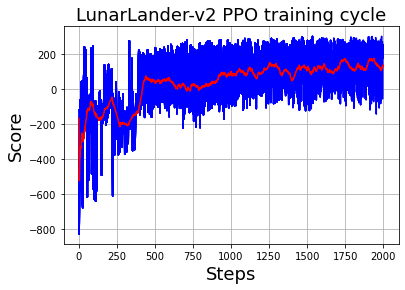

In [10]:
env_name = 'LunarLander-v2'
agent = PPOAgent(env_name, 2000, 10)
agent.run()

episode: 2001/5000, score: 247.7397260283169, average: 136.98 
episode: 2002/5000, score: -22.69328431022143, average: 131.33 
episode: 2003/5000, score: 246.18010202541035, average: 132.02 
episode: 2004/5000, score: 282.4565246033794, average: 140.52 
episode: 2005/5000, score: 267.3307614147151, average: 140.40 
episode: 2006/5000, score: 217.85860944670185, average: 145.96 
episode: 2007/5000, score: 282.5218994473469, average: 147.22 
episode: 2008/5000, score: 10.424173055286811, average: 141.91 
episode: 2009/5000, score: -61.89682381166021, average: 136.11 
episode: 2010/5000, score: 22.89926233164877, average: 137.99 
episode: 2011/5000, score: -92.74685717431242, average: 137.25 
episode: 2012/5000, score: 246.07340142530938, average: 136.69 
episode: 2013/5000, score: -35.451180632560295, average: 135.45 
episode: 2014/5000, score: 284.1177350159986, average: 141.40 
episode: 2015/5000, score: 274.71869197571175, average: 142.28 
episode: 2016/5000, score: 92.29050742460231,

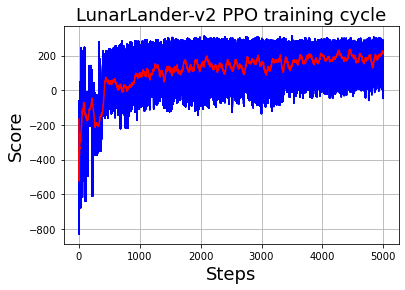

In [11]:
agent.EPISODES = 5000
agent.run()

episode: 5001/6000, score: 300.83196774025, average: 217.41 
episode: 5002/6000, score: 23.745549637791143, average: 213.24 
episode: 5003/6000, score: 264.3979096577742, average: 215.63 
episode: 5004/6000, score: 147.9889556909275, average: 213.44 
episode: 5005/6000, score: 149.35074375825488, average: 211.06 
episode: 5006/6000, score: 268.98242917244903, average: 210.98 
episode: 5007/6000, score: 268.4680211010374, average: 211.31 
episode: 5008/6000, score: 297.5188887996953, average: 211.22 
episode: 5009/6000, score: 273.77186526981825, average: 211.75 
episode: 5010/6000, score: 244.7831001453768, average: 213.74 
episode: 5011/6000, score: 229.66493876876953, average: 213.12 
episode: 5012/6000, score: 260.4433899392842, average: 212.95 
episode: 5013/6000, score: 289.54383330997314, average: 213.92 
episode: 5014/6000, score: 128.90421221367512, average: 211.33 
episode: 5015/6000, score: 264.16157335429256, average: 211.52 
episode: 5016/6000, score: 44.52320610251971, ave

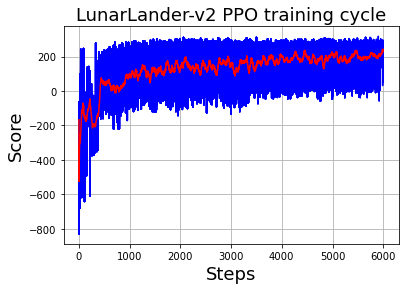

In [12]:
agent.EPISODES = 6000
agent.run()

In [13]:
agent.save()